# SJSU MSDS 255 DL, Spring 2024 - Deep Reinforcement Learning
Homework 13: DQN on gymnasium video games

Git: https://github.com/jrgosalvez/data255_DL

Source: 
- [Gymnasium Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/#lunar-lander)
- [Gym Documentation Box 2d](https://www.gymlibrary.dev/environments/box2d/index.html)
- [Gymnasium wrappers to record](https://gymnasium.farama.org/main/_modules/gymnasium/wrappers/record_video/)
- [Deep Reinforcement Learning](https://medium.com/@sokistar24/introduction-to-deep-reinforcement-learning-solving-the-lunar-lander-c1bb0f6e6f0)
- [Problems pip installing Box2d](https://stackoverflow.com/questions/51811263/problems-pip-installing-box2d)

# Prepare environment

In [4]:
!pip install swig
!pip install box2d-py==2.3.5 --no-build-isolation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.8 MB/s eta 0:00:00a 0:00:01
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-macosx_10_9_x86_64.whl size=398224 sha256=c074b0d80574b9f1f28589350c542b20bc8d3dbf0bb14229e8745e1e6a1d2032
  Stored in directory: /Users/gosalvez/Library/Caches/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py
  Attempting uninstall: box2d-py
    Found existing installation: box2d-py 2.3.8
    Uninstalling box2d-py-2.3.8:
      Successfully uninstalled box2d-py-2.3.8


In [1]:
!pip install moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 4.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 20.2 MB/s eta 0:00:0000:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110727 sha256=19e897093f97bcfce4359dd1194846f77b937deadbf805d1d64e2d9c40707ec4
  Stored in directory: /Users/gosalvez/Library/Caches/pip/wheels/83/b1/d9/119ef7c144b44d591ec0a9a140465133c23ea95d2a161184ba
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [1]:
import gymnasium as gym
import numpy as np
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define parameters

In [2]:
BUFFER_SIZE  = int(1e5)  # replay buffer size
BATCH_SIZE   = 64         # minibatch size
GAMMA        = 0.99            # discount factor
TAU          = 1e-3              # for soft update of target parameters
LR           = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

# Create classes and functions for iterative reinforcement learning

### Create Agent to interact with and learn the environment

In [3]:
class Agent():

    def __init__(self, state_size, action_size, seed):
        #Initialize an Agent object

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local  = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        # Returns actions for given state as per current policy.
        # state (array_like) is the current state
        # eps (float): epsilon; epsilon-greedy action selection
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        #Update value parameters using given batch of experience tuples.
        # experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        # gamma (float): discount factor

        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network 
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        # Soft update model parameters - θ_target = τ*θ_local + (1 - τ)*θ_target
        # local_model (PyTorch model): weights will be copied from
        # target_model (PyTorch model): weights will be copied to
        # tau (float): interpolation parameter 
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### Create relay buffer to store results for learning

In [4]:
class ReplayBuffer:
    #Fixed-size buffer to store experience tuples

    def __init__(self, action_size, buffer_size, batch_size, seed):
        # action_size (int): dimension of each action
        # buffer_size (int): maximum size of buffer
        # batch_size (int): size of each training batch
        # seed (int): random seed

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        # Add a new experience to memory
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        # Randomly sample a batch of experiences from memory
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        # Return the current size of internal memory
        return len(self.memory)

### Create the Deep Q-Network - apply an actor policy model

In [5]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        # state_size (int): Dimension of each state
        # action_size (int): Dimension of each action
        # seed (int): Random seed
        # fc1_units (int): Number of nodes in first hidden layer
        # fc2_units (int): Number of nodes in second hidden layer
        
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        # Map state to action values
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Create training, scoring, and plotting function loop

In [6]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    # n_episodes (int): maximum number of training episodes
    # max_t (int): maximum number of timesteps per episode
    # eps_start (float): starting value of epsilon, for epsilon-greedy action selection
    # eps_end (float): minimum value of epsilon
    # eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize greedy epsilon
    for i_episode in range(1, n_episodes+1):
        state,info = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, info,_ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_lunar.pth') # save trained model for future use
            break
    return scores

### Explore the environment and play an episode to understand the problem and to set parameters for training

*************

#### >>>> SKIP <<< NOTE: python renderer crashes on CPU, so after doing this and recording, skip to training DQN <<<<

In [7]:
env = gym.make('LunarLander-v2',render_mode='human')
observation, info = env.reset(seed=42)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


State shape:  (8,)
Number of actions:  4


In [8]:
# Create the environment
env = gym.make('LunarLander-v2', render_mode='rgb_array')

# Wrap the environment with RecordVideo
env = RecordVideo(env, video_folder='./No_learn_videos', name_prefix='lunar_lander_no_learning')

# Reset the environment
observation, info = env.reset()

for _ in range(1000):
   # Simple policy: choose a random action
   action = env.action_space.sample()
   
   # Apply the action and get the new observation, reward, and other information
   observation, reward, terminated, truncated, info = env.step(action)

   # If the episode is over, reset the environment
   if terminated or truncated:
      observation, info = env.reset()

env.reset()
env.close()

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/No_learn_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/No_learn_videos/lunar_lander_no_learning-episode-0.mp4.
Moviepy - Writing video /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/No_learn_videos/lunar_lander_no_learning-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/No_learn_videos/lunar_lander_no_learning-episode-0.mp4
Moviepy - Building video /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/No_learn_videos/lunar_lander_no_learning-episode-1.mp4.
Moviepy - Writing video /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/No_learn_videos/lunar_lander_no_learning-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/No_learn_videos/lunar_lander_no_learning-episode-1.mp4
Moviepy - Building video /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/No_learn_videos/lunar_lander_no_learning-episode-8.mp4.
Moviepy - Writing video /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/No_learn_videos/lunar_lander_no_learning-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/No_learn_videos/lunar_lander_no_learning-episode-8.mp4


- 8 elements of observation array; however only 6 required. Omit final 2.
- 4 possible action states (up, down, left, right)

# Instantiate the environment and agent with learned environment parameters

In [7]:
# define parameters from environment exploration
env   = gym.make('LunarLander-v2')
agent = Agent(state_size=8, action_size=4, seed=0)

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


**************

### Train DQN and plot convergence

#### >>>> SKIP <<< NOTE: skip training and simpliy load if already have model pretrained model to avoid python render from crashing <<<<

Episode 100	Average Score: -155.70
Episode 200	Average Score: -128.87
Episode 300	Average Score: -36.546
Episode 400	Average Score: 19.315
Episode 500	Average Score: 130.48
Episode 598	Average Score: 200.32
Environment solved in 498 episodes!	Average Score: 200.32


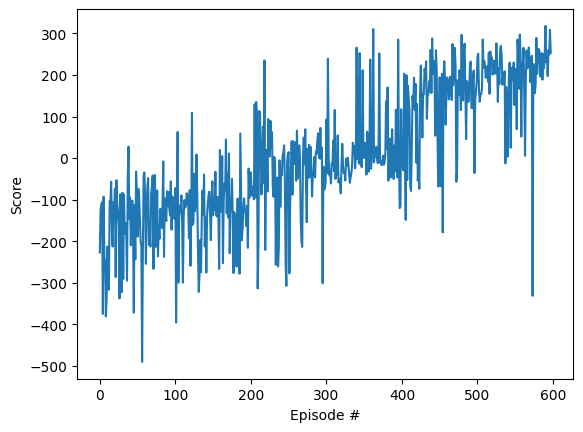

In [8]:
scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

**************

# Load the trained model to record a video

In [9]:
# Load the checkpoint
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_lunar.pth'))

# Create a new environment for rendering
env = gym.make('LunarLander-v2', render_mode='rgb_array')

env = RecordVideo(env, video_folder='./DQN_videos', name_prefix='lunar_lander_DQN')

# Reset the environment
state, info = env.reset()

# Render the environment
while True:
    action = agent.act(state, eps=0.0)  # Use a fixed epsilon value for rendering
    next_state, reward, done, info, _ = env.step(action)
    env.render()
    state = next_state
    if done:
        env.reset()
        env.close()
        break

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/DQN_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/DQN_videos/lunar_lander_DQN-episode-0.mp4.
Moviepy - Writing video /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/DQN_videos/lunar_lander_DQN-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/DQN_videos/lunar_lander_DQN-episode-0.mp4
Moviepy - Building video /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/DQN_videos/lunar_lander_DQN-episode-1.mp4.
Moviepy - Writing video /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/DQN_videos/lunar_lander_DQN-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/gosalvez/Desktop/Git/python_practice/python_practice/HW/DATA255_DL_SPRING2024/HW13/DQN_videos/lunar_lander_DQN-episode-1.mp4


# Load the trained model and visualize

In [10]:
# Load the checkpoint
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_lunar.pth'))

# Create a new environment for rendering
env_render = gym.make('LunarLander-v2', render_mode='human')

# Reset the environment
state, info = env_render.reset()

# Render the environment
while True:
    action = agent.act(state, eps=0.0)  # Use a fixed epsilon value for rendering
    next_state, reward, done, info, _ = env_render.step(action)
    env_render.render()
    state = next_state
    if done:
        print("done")
        env.close()
        break

done
